In [ ]:
#  Step 1: Import Libraries
import pandas as pd#  Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
## Load the Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
# Save Passenger IDs for submission
test_ids = test['PassengerId']
# Step 3: Feature Engineering Function
def preprocess(df):
    df = df.copy()
def preprocess(df):
    df = df.copy()

    
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df = df.drop(['Cabin', 'Name'], axis=1)

    
def preprocess(df):
    df = df.copy()

    # Split Cabin into Deck, Num, Side
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df = df.drop(['Cabin', 'Name'], axis=1)

    # Convert boolean columns
    bool_cols = ['CryoSleep', 'VIP']
    for col in bool_cols:
        df[col] = df[col].astype('bool')

    # Fill missing values
    df['HomePlanet'].fillna('Earth', inplace=True)
    df['Destination'].fillna('TRAPPIST-1e', inplace=True)
    df['Deck'].fillna('F', inplace=True)
    df['Side'].fillna('P', inplace=True)
    df['Age'].fillna(df['Age'].median(), inplace=True)

    # Fill missing expenses with 0
    for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        df[col] = df[col].fillna(0)

    # One-hot encode categorical features
    df = pd.get_dummies(df, drop_first=True)
    return df
import pandas as pd

# Load your CSV file into a DataFrame
df = pd.read_csv('train.csv')  
import pandas as pd

# Load your training data
train_df = pd.read_csv('train.csv')

# Load your testing data 
test_df = pd.read_csv('test.csv')
print(train_df.columns)
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load your dataset
df = pd.read_csv('train.csv')  # This reads the actual CSV file into a DataFrame

# Step 2: Identify your target column — for example, let’s say it’s called 'target'
X = train_df.drop('Transported', axis=1)  # Everything else is a feature
y = train_df['Transported']               # This is what you're predicting

# Step 3: Split your data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
def preprocess(df):
    df = df.copy()

    # Cabin split
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df = df.drop(['Cabin', 'Name'], axis=1)

    # Booleans
    df['CryoSleep'] = df['CryoSleep'].astype('bool')
    df['VIP'] = df['VIP'].astype('bool')

    # ✅ Future-proof fillna
    df['HomePlanet'] = df['HomePlanet'].fillna('Earth')
    df['Destination'] = df['Destination'].fillna('TRAPPIST-1e')
    df['Deck'] = df['Deck'].fillna('F')
    df['Side'] = df['Side'].fillna('P')
    df['Age'] = df['Age'].fillna(df['Age'].median())

    for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        df[col] = df[col].fillna(0)

    df = pd.get_dummies(df, drop_first=True)
    return df
X = preprocess(train.drop('Transported', axis=1))
# Step 5: Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Step 6: Model Training
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

importances = model.feature_importances_
features = X_train.columns

feature_ranking = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# View top 20 features
feature_ranking.head(20)
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.title("Top 15 Most Important Features")
plt.barh(feature_ranking['Feature'][:15][::-1], feature_ranking['Importance'][:15][::-1])
plt.tight_layout()
plt.show()
top_features = feature_ranking['Feature'].head(20).tolist()

# Reduce training/validation data
X_train_reduced = X_train[top_features]
X_val_reduced = X_val[top_features]
model_reduced = RandomForestClassifier(n_estimators=200, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

val_preds_reduced = model_reduced.predict(X_val_reduced)
print("New Accuracy:", accuracy_score(y_val, val_preds_reduced))
# Load test data (assuming test.csv is your test file)
test_df = pd.read_csv('test.csv')

# Optional: Store Passenger IDs for submission
test_ids = test_df['PassengerId']

# Prepare test features (matching the training features)
X_test = test_df.drop('PassengerId', axis=1)  # Or drop other non-feature columns
print(X_test.columns)
print(top_features)
def preprocess_data(df):
    # Existing transformations...
    # Example: Creating 'Num_193' if it's a custom numeric feature
    df['Num_193'] = df['SomeColumn'] * 1.93  # Hypothetical logic

    return df
# Let's say in training you created 'Num_193' as follows:
train_df['Num_193'] = train_df['RoomService'] + train_df['FoodCourt'] + train_df['ShoppingMall']

# Then apply same logic to test data:
test_df['Num_193'] = test_df['RoomService'] + test_df['FoodCourt'] + test_df['ShoppingMall']
# Example: Apply the same transformation pipeline to your test data
def preprocess_data(df):
    # Example: Feature engineering
    df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if pd.notnull(x) else np.nan)
    df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[-1] if pd.notnull(x) else np.nan)
    
    # Fill missing values, encode categorical variables, etc.
    # Example: One-hot encode necessary columns
    df = pd.get_dummies(df, columns=['HomePlanet', 'Destination', 'Deck', 'Side'], drop_first=False)
    
    return df

# Preprocess test set
X_test_preprocessed = preprocess_data(test_df)

# Now filter down to top features
X_test_reduced = X_test_preprocessed[top_features]
top_features = feature_ranking['Feature'].head(20).tolist()
#  Step 7: Evaluation
val_preds = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))

# Preprocess test set
X_test = preprocess(test)

# Align columns with training data
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
# Step 8: Predict on Test Set
test_preds = model.predict(X_test)
#Step 9: Submission File
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': test_preds.astype(bool)
})
submission.to_csv('submission.csv', index=False)
print("✅ Submission ready!")
import joblib

# Save trained model
joblib.dump(model, 'spaceship_model.pkl')

# Save training feature columns for alignment later
joblib.dump(X_train.columns.tolist(), 'spaceship_columns.pkl')
import joblib

joblib.dump(model_reduced, 'spaceship_model_reduced.pkl', compress=3)
import os
print(os.path.getsize('spaceship_model_reduced.pkl') / 1024 / 1024, "MB")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer

In [3]:
## Load the Data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# Save Passenger IDs for submission
test_ids = test['PassengerId']

In [5]:
# Step 3: Feature Engineering Function
def preprocess(df):
    df = df.copy()

In [6]:
def preprocess(df):
    df = df.copy()

    
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df = df.drop(['Cabin', 'Name'], axis=1)

    

In [7]:
def preprocess(df):
    df = df.copy()

    # Split Cabin into Deck, Num, Side
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df = df.drop(['Cabin', 'Name'], axis=1)

    # Convert boolean columns
    bool_cols = ['CryoSleep', 'VIP']
    for col in bool_cols:
        df[col] = df[col].astype('bool')

    # Fill missing values
    df['HomePlanet'].fillna('Earth', inplace=True)
    df['Destination'].fillna('TRAPPIST-1e', inplace=True)
    df['Deck'].fillna('F', inplace=True)
    df['Side'].fillna('P', inplace=True)
    df['Age'].fillna(df['Age'].median(), inplace=True)

    # Fill missing expenses with 0
    for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        df[col] = df[col].fillna(0)

    # One-hot encode categorical features
    df = pd.get_dummies(df, drop_first=True)
    return df

In [8]:
import pandas as pd

# Load your CSV file into a DataFrame
df = pd.read_csv('train.csv')  

In [9]:
import pandas as pd

# Load your training data
train_df = pd.read_csv('train.csv')

# Load your testing data 
test_df = pd.read_csv('test.csv')

In [10]:
print(train_df.columns)

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Load your dataset
df = pd.read_csv('train.csv')  # This reads the actual CSV file into a DataFrame

# Step 2: Identify your target column — for example, let’s say it’s called 'target'
X = train_df.drop('Transported', axis=1)  # Everything else is a feature
y = train_df['Transported']               # This is what you're predicting

# Step 3: Split your data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
def preprocess(df):
    df = df.copy()

    # Cabin split
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df = df.drop(['Cabin', 'Name'], axis=1)

    # Booleans
    df['CryoSleep'] = df['CryoSleep'].astype('bool')
    df['VIP'] = df['VIP'].astype('bool')

    # ✅ Future-proof fillna
    df['HomePlanet'] = df['HomePlanet'].fillna('Earth')
    df['Destination'] = df['Destination'].fillna('TRAPPIST-1e')
    df['Deck'] = df['Deck'].fillna('F')
    df['Side'] = df['Side'].fillna('P')
    df['Age'] = df['Age'].fillna(df['Age'].median())

    for col in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        df[col] = df[col].fillna(0)

    df = pd.get_dummies(df, drop_first=True)
    return df

In [13]:
X = preprocess(train.drop('Transported', axis=1))

In [14]:
# Step 5: Train/Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Step 6: Model Training
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [16]:
importances = model.feature_importances_
features = X_train.columns

feature_ranking = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# View top 20 features
feature_ranking.head(20)

,Feature,Importance
6,Spa,0.065102
7,VRDeck,0.061456
3,RoomService,0.059470
0,CryoSleep,0.057665
4,FoodCourt,0.050090
5,ShoppingMall,0.044827
1,Age,0.037607
8700,HomePlanet_Europa,0.016742
8701,HomePlanet_Mars,0.011523
10527,Side_S,0.010116


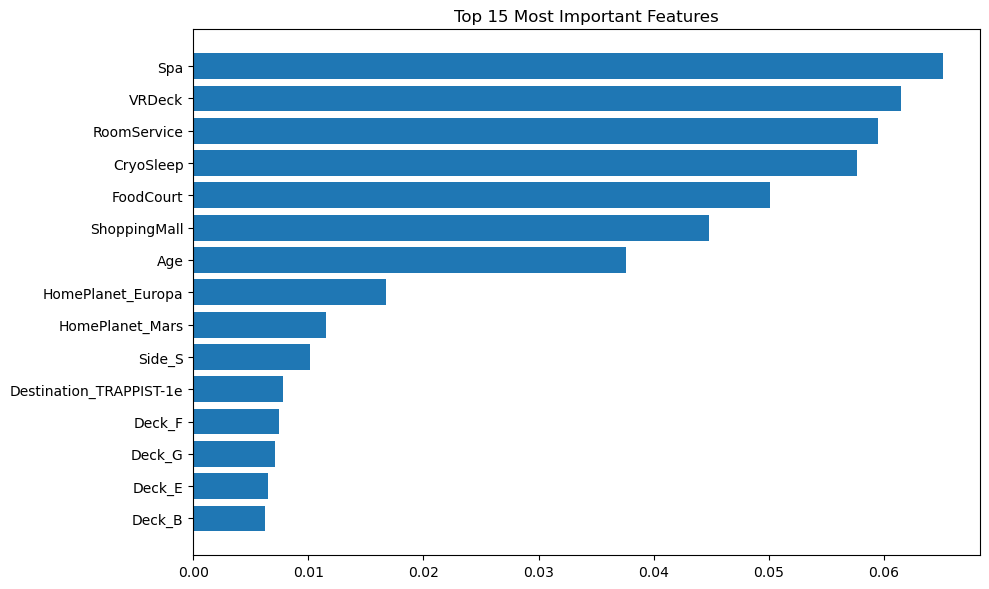

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.title("Top 15 Most Important Features")
plt.barh(feature_ranking['Feature'][:15][::-1], feature_ranking['Importance'][:15][::-1])
plt.tight_layout()
plt.show()

In [18]:
top_features = feature_ranking['Feature'].head(20).tolist()

# Reduce training/validation data
X_train_reduced = X_train[top_features]
X_val_reduced = X_val[top_features]

In [19]:
model_reduced = RandomForestClassifier(n_estimators=200, random_state=42)
model_reduced.fit(X_train_reduced, y_train)

val_preds_reduced = model_reduced.predict(X_val_reduced)
print("New Accuracy:", accuracy_score(y_val, val_preds_reduced))

New Accuracy: 0.7763082231167338


In [20]:
# Load test data (assuming test.csv is your test file)
test_df = pd.read_csv('test.csv')

# Optional: Store Passenger IDs for submission
test_ids = test_df['PassengerId']

# Prepare test features (matching the training features)
X_test = test_df.drop('PassengerId', axis=1)  # Or drop other non-feature columns

In [21]:
print(X_test.columns)
print(top_features)

Index(['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP',
       'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name'],
      dtype='object')
['Spa', 'VRDeck', 'RoomService', 'CryoSleep', 'FoodCourt', 'ShoppingMall', 'Age', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Side_S', 'Destination_TRAPPIST-1e', 'Deck_F', 'Deck_G', 'Deck_E', 'Deck_B', 'Deck_C', 'Destination_PSO J318.5-22', 'VIP', 'Deck_D', 'Num_193']


In [22]:
def preprocess_data(df):
    # Existing transformations...
    # Example: Creating 'Num_193' if it's a custom numeric feature
    df['Num_193'] = df['SomeColumn'] * 1.93  # Hypothetical logic

    return df

In [23]:
# Let's say in training you created 'Num_193' as follows:
train_df['Num_193'] = train_df['RoomService'] + train_df['FoodCourt'] + train_df['ShoppingMall']

# Then apply same logic to test data:
test_df['Num_193'] = test_df['RoomService'] + test_df['FoodCourt'] + test_df['ShoppingMall']

In [24]:
# Example: Apply the same transformation pipeline to your test data
def preprocess_data(df):
    # Example: Feature engineering
    df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if pd.notnull(x) else np.nan)
    df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[-1] if pd.notnull(x) else np.nan)
    
    # Fill missing values, encode categorical variables, etc.
    # Example: One-hot encode necessary columns
    df = pd.get_dummies(df, columns=['HomePlanet', 'Destination', 'Deck', 'Side'], drop_first=False)
    
    return df

# Preprocess test set
X_test_preprocessed = preprocess_data(test_df)

# Now filter down to top features
X_test_reduced = X_test_preprocessed[top_features]

In [25]:
top_features = feature_ranking['Feature'].head(20).tolist()

In [26]:
#  Step 7: Evaluation
val_preds = model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))


Accuracy: 0.78953421506613
              precision    recall  f1-score   support

       False       0.78      0.80      0.79       861
        True       0.80      0.78      0.79       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [27]:
# Preprocess test set
X_test = preprocess(test)

# Align columns with training data
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [28]:
# Step 8: Predict on Test Set
test_preds = model.predict(X_test)

In [29]:
#Step 9: Submission File
submission = pd.DataFrame({
    'PassengerId': test_ids,
    'Transported': test_preds.astype(bool)
})

In [30]:
submission.to_csv('submission.csv', index=False)
print("✅ Submission ready!")

✅ Submission ready!


In [31]:
import joblib

# Save trained model
joblib.dump(model, 'spaceship_model.pkl')

# Save training feature columns for alignment later
joblib.dump(X_train.columns.tolist(), 'spaceship_columns.pkl')

['spaceship_columns.pkl']

In [32]:
import joblib

joblib.dump(model_reduced, 'spaceship_model_reduced.pkl', compress=3)

['spaceship_model_reduced.pkl']

In [33]:
import os
print(os.path.getsize('spaceship_model_reduced.pkl') / 1024 / 1024, "MB")

6.441606521606445 MB


In [34]:
import joblib

# After selecting top features
top_features = feature_ranking['Feature'].head(20).tolist()

# Save reduced columns
joblib.dump(top_features, 'spaceship_columns_reduced.pkl', compress=3)

['spaceship_columns_reduced.pkl']